# 🏫 Previsão de Evasão Escolar 
## 📚 Importando bibliotecas que serão utilizadas

In [32]:
import os
import sys
import numpy as np
from pathlib import Path
from keras import optimizers
from keras.layers import Dense
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from keras.models import Sequential
from sklearn import model_selection
from matplotlib import pyplot as plt
from IPython.display import Markdown
from keras.callbacks import EarlyStopping
localizacao_reduzir_dados = os.path.join(os.getcwd(), '..')
sys.path.append(localizacao_reduzir_dados)
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from tratamento_dados.reduzir_dados import reduzir_dados
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## 🎲 Tratamento de Dados
#### 1. Trazer arquivo de dados de outras pastas.

In [2]:
data_folder = Path("../tratamento_dados/dados/")

ED_BRASILEIRA_2022_PATH = data_folder / 'ed_brasileira_2022.csv'
ED_BRASILEIRA_2022_REDU_PATH = data_folder / 'ed_brasileira_2022_redu.csv'

ed_brasileira_2022_redu_df = reduzir_dados(ED_BRASILEIRA_2022_PATH, ED_BRASILEIRA_2022_REDU_PATH)

#### 2. Construir a matriz $X$ e o vetor $y$ de entrada para o classificador.

In [3]:
X = np.array(ed_brasileira_2022_redu_df.drop(['taxa_de_abandono'], axis=1))
y = np.array(ed_brasileira_2022_redu_df['taxa_de_abandono'])

#### 3. Identificar o número de exemplos ($N$) e número de features.

In [4]:
nRow = X.shape[0] 
nCol = X.shape[1]
display(Markdown(f"#### Número de exemplos ($N$): **{nRow}**, número de features: **{nCol}**."))

#### Número de exemplos ($N$): **19196**, número de features: **18**.

#### 4. Separar os dados ($X$, $y$) entre treinamento e teste.
- `RANDOM_STATE`: número que garante reprodutibilidade dos resultados, garantindo que a divisão dos dados em treinamento e teste seja a mesma toda vez que o código é executado.
- Tamanho do teste: 20%

In [5]:
RANDOM_STATE = 2 

X_train, X_test, y_train, y_test =  model_selection.train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

#### 5. Análise dos dados da função alvo.

(15356,)


(array([7511.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        7845.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

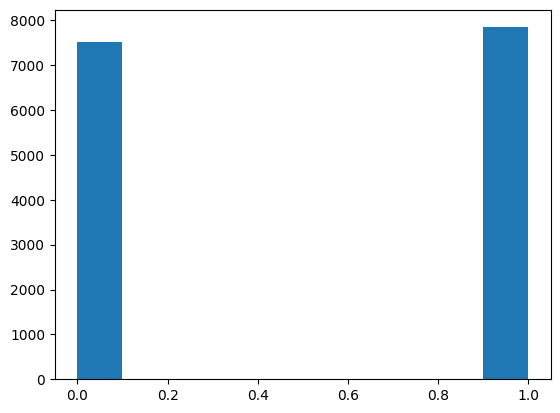

In [6]:
print(y_train.shape)
plt.hist(y_train)

## 🧠 Implementação do modelo baseado em Rede Neural
#### 1.  Definição da Arquitetura da Rede Neural 

In [7]:
DS, d = X_train.shape
quantidade_de_neuronios = int(abs((abs(DS) - 10)/(10*(d + 2))))
quantidade_de_neuronios

76

In [8]:
model = Sequential()
BATCH_SIZE = 128  

model.add(Dense(quantidade_de_neuronios, input_dim=d, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) 

sgd = optimizers.SGD(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

history = model.fit(X_train, y_train, epochs=100, batch_size=BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 76)                1444      
                                                                 
 dense_1 (Dense)             (None, 1)                 77        
                                                                 
Total params: 1521 (5.94 KB)
Trainable params: 1521 (5.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
120/120 [==============================] - 1s 1ms/step - loss: 0.6742 - accuracy: 0.5410
Epoch 2/100
120/120 [==============================] - 0s 1ms/step - loss: 0.6456 - accuracy: 0.6867
Epoch 3/100
120/120 [==============================] - 0s 959us/step - loss: 0.6129 - accuracy: 0.7611
Epoch 4/100
120/120 [==============================] - 0s 1ms/step - loss: 0.5776 - accuracy: 0.7800
Epoch 5/1

- Performance do modelo

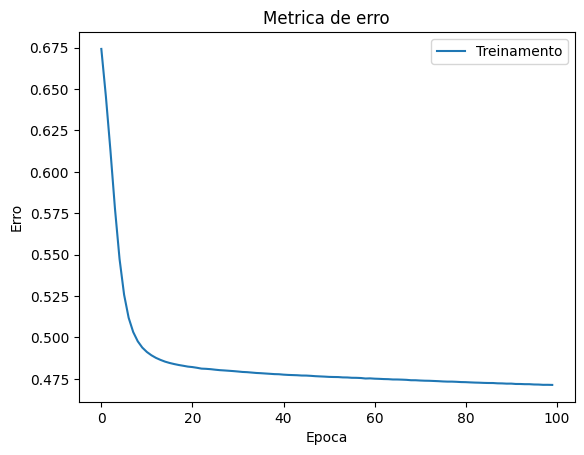

480/480 [==============================] - 1s 2ms/step

--> Acuracia (treino): 0.7979
--> Acuracia (teste): 0.7982
--> E_out - E_in = -0.0040
--> acc_train - acc_test = -0.0003


In [9]:
plt.plot(history.history['loss'])
plt.title('Metrica de erro')
plt.ylabel('Erro')
plt.xlabel('Epoca')
plt.legend(['Treinamento'])
plt.show()

pred = np.round(model.predict(X_train))
acc_train = accuracy_score(y_train, pred)

# Obtendo a acuracia usando evaluate()
E_out, acc_test = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)

print(f'\n--> Acuracia (treino): {acc_train:.4f}')
print(f'--> Acuracia (teste): {acc_test:.4f}')
print(f"--> E_out - E_in = {E_out - history.history['loss'][-1]:.4f}")
print(f"--> acc_train - acc_test = {acc_train - acc_test:.4f}")

In [10]:
X_train, X_val, y_train, y_val =  model_selection.train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=0.2)

#### 1.2. Computar o *Ein* e *Eout* para analisar a existência de overfitting
- Calculando a validação do modelo

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=BATCH_SIZE)

Epoch 1/150
96/96 [==============================] - 0s 4ms/step - loss: 0.4687 - accuracy: 0.8002 - val_loss: 0.4813 - val_accuracy: 0.7897
Epoch 2/150
96/96 [==============================] - 0s 3ms/step - loss: 0.4686 - accuracy: 0.8002 - val_loss: 0.4813 - val_accuracy: 0.7897
Epoch 3/150
96/96 [==============================] - 0s 2ms/step - loss: 0.4685 - accuracy: 0.8001 - val_loss: 0.4815 - val_accuracy: 0.7894
Epoch 4/150
96/96 [==============================] - 0s 3ms/step - loss: 0.4683 - accuracy: 0.8005 - val_loss: 0.4818 - val_accuracy: 0.7891
Epoch 5/150
96/96 [==============================] - 0s 3ms/step - loss: 0.4682 - accuracy: 0.8001 - val_loss: 0.4812 - val_accuracy: 0.7897
Epoch 6/150
96/96 [==============================] - 0s 3ms/step - loss: 0.4682 - accuracy: 0.8006 - val_loss: 0.4813 - val_accuracy: 0.7946
Epoch 7/150
96/96 [==============================] - 0s 3ms/step - loss: 0.4682 - accuracy: 0.8004 - val_loss: 0.4815 - val_accuracy: 0.7943
Epoch 8/150
9

In [12]:
def plotar_acuracia_e_in_e_out(X_train, X_val, y_train, y_val, history):
    fig, ax = plt.subplots()
    
    ax.plot(history.history['loss'], label='Treinamento')
    ax.plot(history.history['val_loss'], label='Validação')
    
    ax.set_title('Métrica de Erro')
    ax.set_ylabel('Erro')
    ax.set_xlabel('Época')
    
    ax.legend()
    plt.show()

    pred_train = np.round(model.predict(X_train))
    pred_val = np.round(model.predict(X_val))

    acc_train = accuracy_score(y_train, pred_train)
    acc_val = accuracy_score(y_val, pred_val)

    print(f'--> Acurácia (treino): {acc_train:.6f}')
    print(f'--> Acurácia (validação): {acc_val:.6f}')

    print(f"acc_train - acc_val = {acc_train - acc_val:.6f}")
    print(f"E_val - E_in = {(history.history['val_loss'][-1] - history.history['loss'][-1]):.6f}")

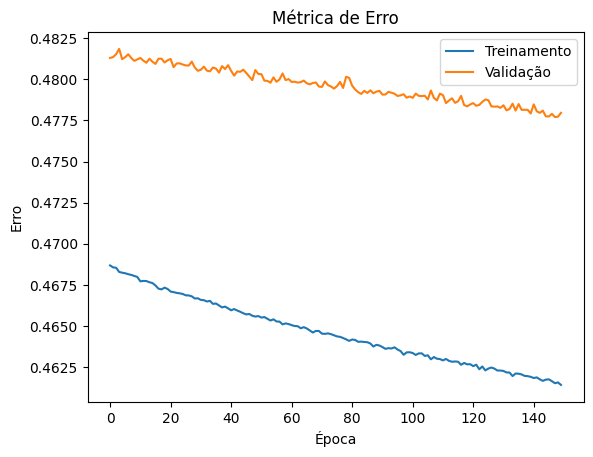

96/96 [==============================] - 0s 682us/step
--> Acurácia (treino): 0.800635
--> Acurácia (validação): 0.789388
acc_train - acc_val = 0.011247
E_val - E_in = 0.016538


In [13]:
plotar_acuracia_e_in_e_out(X_train, X_val, y_train, y_val, history)

In [14]:
# Normalizacao de dados
min_values = X.min(axis=0)
max_values = X.max(axis=0)
X = (X - min_values) / (max_values - min_values)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, random_state=RANDOM_STATE, test_size=0.2)

#### Tratando a overfitting

In [15]:
# Treinamento COM Early Stopping

# val_loss = quantidade a ser monitorada, mode = o treinamento vai parar quando quando a quantidade monitorada parou de diminuir, 
# verbose = mostra a época em que parou de diminuir, patience = número de épocas que ainda são testadas depois do treinamento achar a melhor acurácia.
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 76)                1444      
                                                                 
 dense_1 (Dense)             (None, 1)                 77        
                                                                 
Total params: 1521 (5.94 KB)
Trainable params: 1521 (5.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/150
96/96 [==============================] - 1s 2ms/step - loss: 0.5245 - accuracy: 0.7592 - val_loss: 0.4989 - val_accuracy: 0.7803
Epoch 2/150
96/96 [==============================] - 0s 2ms/step - loss: 0.4830 - accuracy: 0.7896 - val_loss: 0.4920 - val_accuracy: 0.7819
Epoch 3/150
96/96 [==============================] - 0s 2ms/step - loss: 0.4779 - accuracy: 0.7916 - val_loss: 0.4895 - val_accuracy: 0.7874
Epoch 4/150
96/96 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7934 - val_loss: 0.4865 - val_accuracy: 0.7832
Epoch 5/150
96/96 [==============================] - 0s 1ms/step - loss: 0.4722 - accuracy: 0.7936 - val_loss: 0.4876 - val_accuracy: 0.7913
Epoch 6/150
96/96 [==============================] - 0s 2ms/step - loss: 0.4706 - accuracy: 0.7972 - val_loss: 0.4836 - val_accuracy: 0.7865
Epoch 7/150
96/96 [==============================] - 0s 1ms/step - loss: 0.4695 - accuracy: 0.7975 - val_loss: 0.4831 - val_accuracy: 0.7868
Epoch 8/150
9

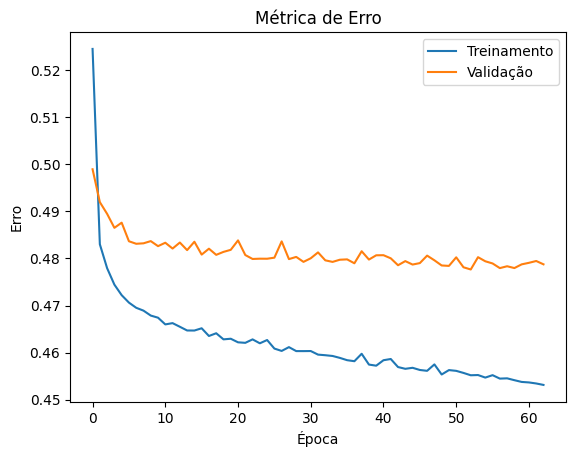

96/96 [==============================] - 0s 975us/step
--> Acurácia (treino): 0.805275
--> Acurácia (validação): 0.791016
acc_train - acc_val = 0.014260
E_val - E_in = 0.025619


In [17]:
plotar_acuracia_e_in_e_out(X_train, X_val, y_train, y_val, history)

### Usando o K-Fold Cross Validation para validar o modelo usando todo o conjunto de treinamento

In [18]:
# Configuração do StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

modelos_fold = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    model.add(Dense(quantidade_de_neuronios, input_dim=d, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid')) 

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    dados_modelo = [X_train_fold, X_val_fold, y_train_fold, y_val_fold]
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=100, batch_size=BATCH_SIZE, verbose=1)
    
    modelos_fold.append((model, dados_modelo, history))

Epoch 1/100
96/96 [==============================] - 1s 3ms/step - loss: 0.6695 - accuracy: 0.5631 - val_loss: 0.6301 - val_accuracy: 0.7383
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5870 - accuracy: 0.7833 - val_loss: 0.5559 - val_accuracy: 0.7868
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5415 - accuracy: 0.8004 - val_loss: 0.5312 - val_accuracy: 0.7962
Epoch 4/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5243 - accuracy: 0.8035 - val_loss: 0.5199 - val_accuracy: 0.7920
Epoch 5/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5143 - accuracy: 0.8023 - val_loss: 0.5115 - val_accuracy: 0.7956
Epoch 6/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5061 - accuracy: 0.8037 - val_loss: 0.5037 - val_accuracy: 0.7956
Epoch 7/100
96/96 [==============================] - 0s 2ms/step - loss: 0.5006 - accuracy: 0.8022 - val_loss: 0.4976 - val_accuracy: 0.7985
Epoch 8/100
9

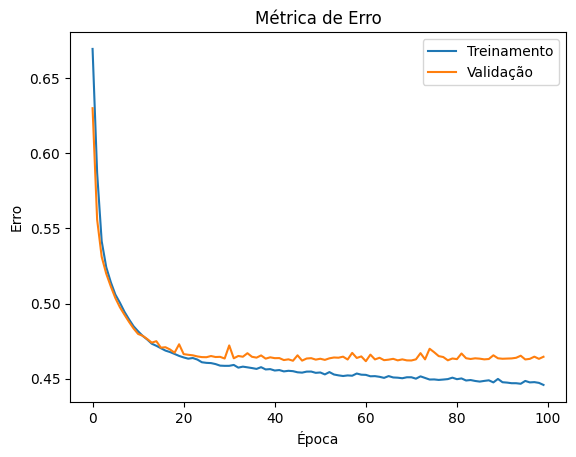

96/96 [==============================] - 0s 975us/step
--> Acurácia (treino): 0.819033
--> Acurácia (validação): 0.821615
acc_train - acc_val = -0.002582
E_val - E_in = 0.018736


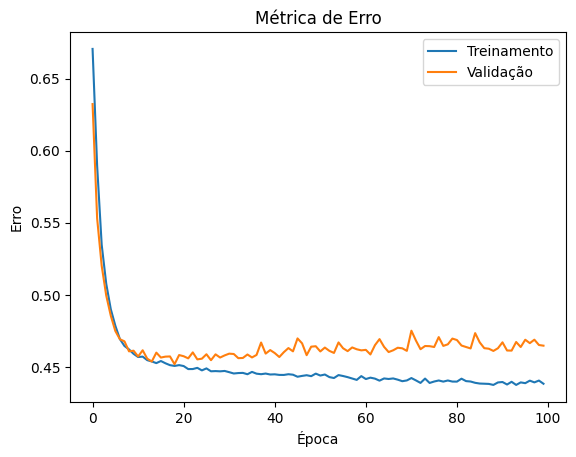

96/96 [==============================] - 0s 877us/step
--> Acurácia (treino): 0.817745
--> Acurácia (validação): 0.826767
acc_train - acc_val = -0.009021
E_val - E_in = 0.026396


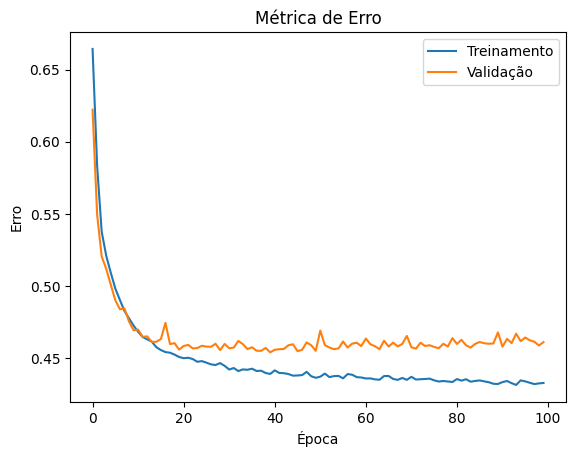

96/96 [==============================] - 0s 744us/step
--> Acurácia (treino): 0.818803
--> Acurácia (validação): 0.822533
acc_train - acc_val = -0.003730
E_val - E_in = 0.028326


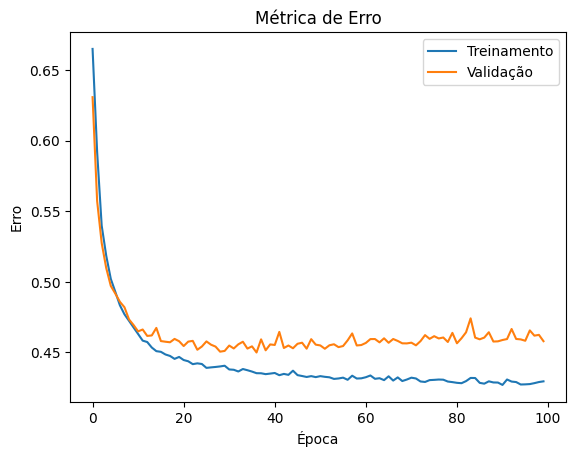

96/96 [==============================] - 0s 1ms/step
--> Acurácia (treino): 0.818885
--> Acurácia (validação): 0.822208
acc_train - acc_val = -0.003323
E_val - E_in = 0.028430


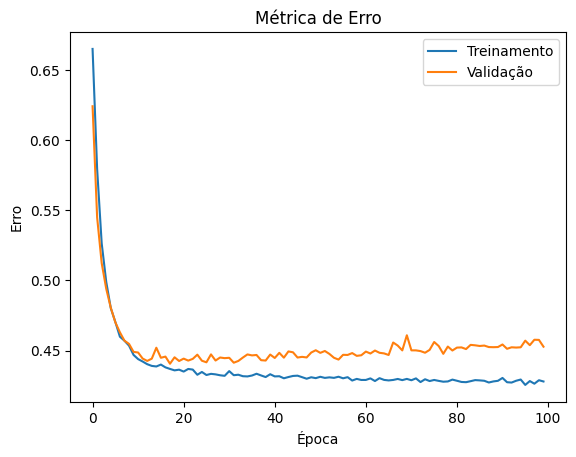

96/96 [==============================] - 0s 827us/step
--> Acurácia (treino): 0.823280
--> Acurácia (validação): 0.804624
acc_train - acc_val = 0.018657
E_val - E_in = 0.024826


In [19]:
for _, dados_modelo, history in modelos_fold:
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = dados_modelo     
    plotar_acuracia_e_in_e_out(X_train_fold, X_val_fold, y_train_fold, y_val_fold, history)

In [20]:
melhor_modelo = None
melhor_acuracia = 0.0

for modelo, dados_modelo, _ in modelos_fold:
    X_val, y_val = dados_modelo[1], dados_modelo[3]
    
    pred_val = np.round(model.predict(X_val))
    acc_val = accuracy_score(y_val, pred_val)
    
    if acc_val > melhor_acuracia:
        melhor_acuracia = acc_val
        melhor_modelo = modelo

# Realizar predições no conjunto de teste
predictions = melhor_modelo.predict(X_test)
pred_test_labels = np.argmax(predictions, axis=1)

print(f'Acurácia do melhor modelo com dados de validação: {round(melhor_acuracia, 3)}')

120/120 [==============================] - 0s 862us/step
Acurácia do melhor modelo com dados de validação: 0.827


In [21]:
accuracy = accuracy_score(y_test, pred_test_labels)
print(f'Acurácia do melhor modelo com dados de teste: {accuracy:.4f}')

precision = precision_score(y_test, pred_test_labels, average='macro')  # 'macro' ignora o desbalanceamento de classes
print(f'Precisão do melhor modelo com dados de teste: {precision:.4f}')

recall = recall_score(y_test, pred_test_labels, average='macro')
print(f'Recall do melhor modelo com dados de teste: {recall:.4f}')

f1 = f1_score(y_test, pred_test_labels, average='macro')
print(f'F1 Score do melhor modelo com dados de teste: {f1:.4f}')

Acurácia do melhor modelo com dados de teste: 0.4924
Precisão do melhor modelo com dados de teste: 0.2462
Recall do melhor modelo com dados de teste: 0.5000
F1 Score do melhor modelo com dados de teste: 0.3300


c:\Users\gabri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 🌳 Árvore de decisão

In [22]:
RANDOM_STATE = 2 
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

In [23]:
arvore = DecisionTreeClassifier()
arvore.fit(X_train, y_train)

E_in = (1 - accuracy_score(y_train, arvore.predict(X_train)))
E_out = (1 - accuracy_score(y_test, arvore.predict(X_test)))

print('E_in: %0.4f' % E_in)
print('E_out: %0.4f' % E_out)

print(f'E_out - E_in: {E_out - E_in}')

print(classification_report(y_test, arvore.predict(X_test)))

E_in: 0.1666
E_out: 0.2172
E_out - E_in: 0.050607661500390755
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      1891
           1       0.82      0.74      0.78      1949

    accuracy                           0.78      3840
   macro avg       0.79      0.78      0.78      3840
weighted avg       0.79      0.78      0.78      3840



In [24]:
def plotar_arvore(arvore, X, y):
    plt.figure(figsize=(20,10))
    plot_tree(arvore, filled=True, feature_names=pd.DataFrame(X).columns, proportion=True, rounded=True, class_names=np.unique(y).astype(str))

    plt.show()

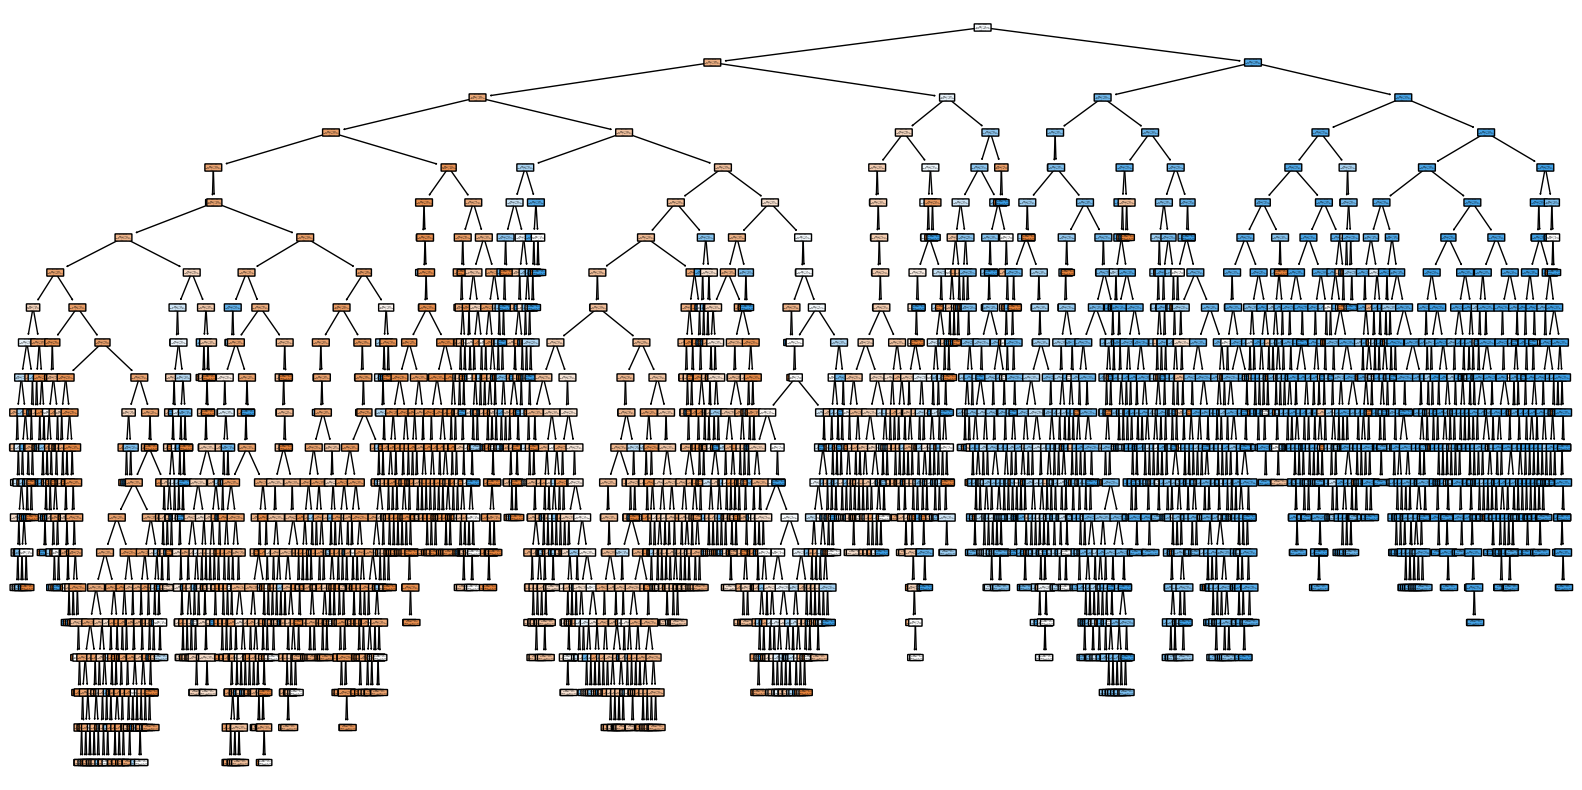

In [25]:
plotar_arvore(arvore, X, y)

In [29]:
caminhos = arvore.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurezas = caminhos.ccp_alphas, caminhos.impurities

arvores = []

for ccp_alpha in ccp_alphas:
    # Por imprecisoes numericas esse valor pode ser levemente negativo, por isso utiliza-se zero
    # caso negativo
    ccp_alpha = max(ccp_alpha, 0)
    arvore = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    arvore.fit(X_train, y_train)
    arvores.append(arvore)

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
valores_alpha = []

for ccp_alpha in ccp_alphas:
    ccp_alpha = max(ccp_alpha, 0) 
    arvore = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=ccp_alpha)
    valores = cross_val_score(arvore, X_train, y_train, cv=skf, scoring='accuracy')
    valores_alpha.append(np.mean(valores))

In [31]:
melhor_alpha = ccp_alphas[np.argmax(valores_alpha)]
melhor_arvore = DecisionTreeClassifier(random_state=RANDOM_STATE, ccp_alpha=melhor_alpha)
melhor_arvore.fit(X_train, y_train)

print(f'Melhor ccp_alpha: {melhor_alpha}')
print(f'Acurácia média maxima no Cross Validation: {max(valores_alpha):.4f}')

Melhor ccp_alpha: 0.0001931032897660236
Acurácia média maxima no Cross Validation: 0.8011


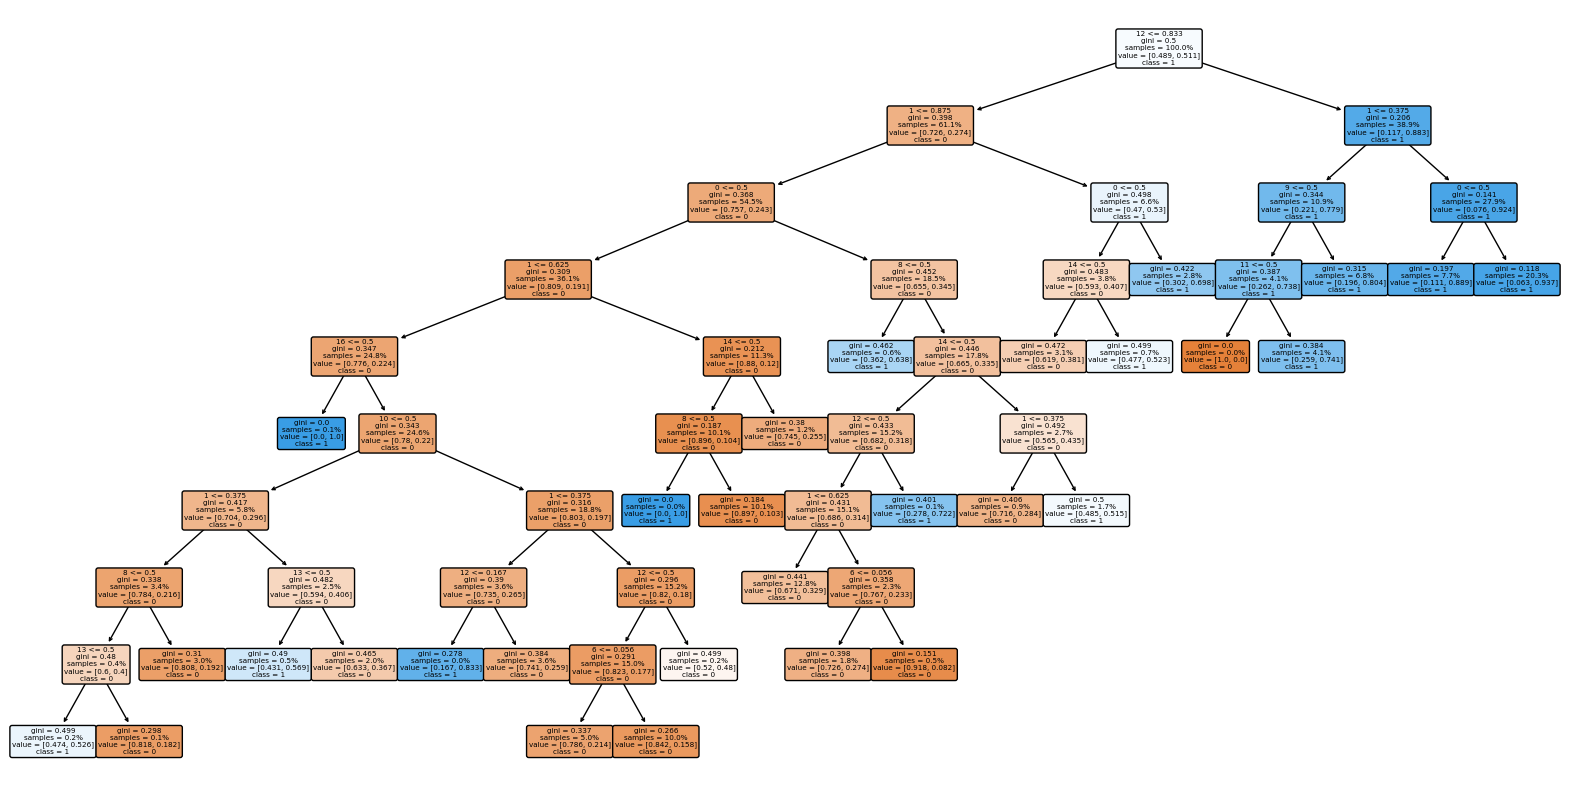

              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1891
           1       0.83      0.76      0.80      1949

    accuracy                           0.80      3840
   macro avg       0.80      0.80      0.80      3840
weighted avg       0.80      0.80      0.80      3840



In [33]:
plotar_arvore(melhor_arvore, X, y)

predictions = melhor_arvore.predict(X_test)
print(classification_report(y_test, predictions))